In [1]:
#!pip install numpy
#!pip install gym
#!pip install matplotlib
#!pip install opencv-python
#!apt-get install ffmpeg libsm6 libxext6  -y
#!apt-get update

In [2]:
#!pip install tensorflow


In [3]:
#!pip install wandb

In [4]:
#import wandb
#wandb.login()

In [5]:
#wandb.init(project="rl_object_avoid", entity="tharhtetsan")

In [6]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random
import math
from gym import Env, spaces
import time
font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

In [7]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
    
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

In [8]:
class Robot(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Robot, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("robot.PNG") / 255.0
        self.icon_w = 20
        self.icon_h = 20
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

In [9]:
class Obstical(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Obstical, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("building.png") / 255.0
        self.icon_w = 30
        self.icon_h = 30
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))
        

In [10]:
class Flag(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Flag, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("flag.PNG") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

In [11]:
class Robot_Env(Env):
    def __init__(self):
        super(Robot_Env, self).__init__()
        
        # Define a 2-D observation space
        self.observation_shape = (400, 400, 3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
        
        # Define an action space ranging from 0 to 4
        self.action_space = spaces.Discrete(6,)
        
         # Create a canvas to render the environment images upon 
        self.canvas = np.ones(self.observation_shape) * 1
        
        self.elements = []
        self.max_fuel = 150
        
        
        self.y_min = int (self.observation_shape[0] * 0.1)
        self.x_min = 0
        self.y_max = int (self.observation_shape[0] * 0.9)
        self.x_max = self.observation_shape[1]
       
    
    
    def step(self, action):
        done = False
        assert self.action_space.contains(action), "Invalid Action"
        # Decrease the fuel counter 
        self.fuel_left -= 1 
        # Reward for executing a step.
       
        
        
        if action == 0:
            self.robot.move(0,5)
        elif action == 1:
            self.robot.move(0,-5)
        elif action == 2:
            self.robot.move(5,0)
        elif action == 3:
            self.robot.move(-5,0)
        elif action == 4:
            self.robot.move(0,0)
            
        
        
        
        
        reward = 0 
        
        for elem in self.elements:
            ## check robot hit building
            if isinstance(elem, Obstical):
                if self.has_collided(self.robot, elem):
                    # Conclude the episode and remove the chopper from the Env.
                    done = True
                    reward = -10
                    #self.elements.remove(self.robot)

            elif isinstance(elem, Flag):
                if self.has_collided(self.robot, elem):
                    done = True
                    reward = 100
                    self.elements.remove(self.robot)

                else:
                    robot_x, robot_y = self.robot.get_position()
                    goal_x,goal_y = elem.get_position()
                    dist =  math.sqrt((goal_x -robot_x)**2+(goal_y-robot_y)**2)
                    reward = (1/dist) * 1000
                        
                        

                
    
         # Increment the episodic return
        self.ep_return += reward
        
        # Draw elements on the canvas
        self.draw_elements_on_canvas()
        
        # If out of fuel, end the episode.
        if self.fuel_left == 0:
            done = True

        return self.canvas, reward, done, []
            
    
    
        
    def reset(self):
        # Reset the fuel consumed
        self.fuel_left = self.max_fuel

        # Reset the reward
        self.ep_return  = 0
        
        
        # Number of birds
        self.obstical_count = 0
        
        
        x = random.randrange(int(self.observation_shape[0] * 0.05), int(self.observation_shape[0] * 0.10))
        y = random.randrange(int(self.observation_shape[1] * 0.15), int(self.observation_shape[1] * 0.20))
        
        self.robot = Robot("Robot", self.x_max, self.x_min, self.y_max, self.y_min)
        self.robot.set_position(x,y)
        
        
         # Intialise the elements 
        self.elements = [self.robot]
        
        
        # Reset the Canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw elements on the canvas
        self.draw_elements_on_canvas()


        # return the observation
        return self.canvas 
    
    
    
    def set_obsticals(self,points):
        for obstical_x, obstical_y in points:
            obstical_obj  =  Obstical("obstical_{}".format(self.obstical_count), self.x_max, self.x_min, self.y_max, self.y_min) 
            obstical_obj.set_position(obstical_x, obstical_y)
            self.elements.append(obstical_obj)
            self.draw_elements_on_canvas()
        return self.canvas

    def set_goal(self,points):
        for flag_x, flag_y in  points:
            flag_obj = Flag("flag_{}".format(self.obstical_count), self.x_max, self.x_min, self.y_max, self.y_min) 
            flag_obj.set_position(flag_x, flag_y)
            self.elements.append(flag_obj)
            self.draw_elements_on_canvas()
        return self.canvas
    
    def draw_elements_on_canvas(self):
        # Init the canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw the heliopter on canvas
        for elem in self.elements:
            elem_shape = elem.icon.shape
            x,y = elem.x, elem.y
            self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = elem.icon

        text = 'Fuel Left: {} | Rewards: {}'.format(self.fuel_left, self.ep_return)

        # Put the info on canvas 
        self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
                   0.8, (0,0,0), 1, cv2.LINE_AA)
        
    def get_action_meanings(self):
        return {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "Do Nothing"}
    
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            cv2.imshow("Obstacle Avoidance Robot", self.canvas)
            cv2.waitKey(10)

        elif mode == "rgb_array":
            return self.canvas
        
    def close(self):
        cv2.destroyAllWindows()
        
    def has_collided(self, elem1, elem2):
        x_col = False
        y_col = False

        elem1_x, elem1_y = elem1.get_position()
        elem2_x, elem2_y = elem2.get_position()

        if 2 * abs(elem1_x - elem2_x) <= (elem1.icon_w + elem2.icon_w):
            x_col =  True

        if 2 * abs(elem1_y - elem2_y) <= (elem1.icon_h + elem2.icon_h):
            y_col = True

        if x_col and y_col:
            return True

        return False

C:\Users\tharh\anaconda3\envs\tharhtet\lib\site-packages\gym\spaces\box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


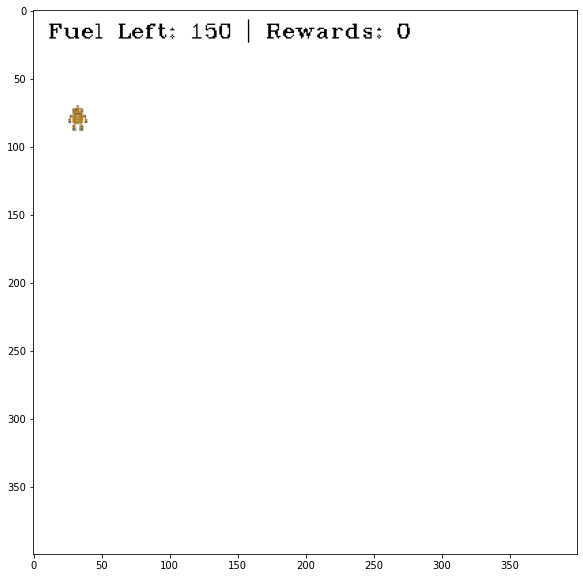

In [12]:
env = Robot_Env()
obs = env.reset()
plt.figure(figsize=(10, 10))
plt.imshow(obs)

In [13]:
full_obstacle_list = [ (200,100), (400,150),(400, 110), 
                 (430, 390), (201, 304), (135, 281), 
                 (286, 373), (175, 280), (250, 375), (139, 327), (369, 278), 
                 (295, 196), (210, 111),(110,110)]

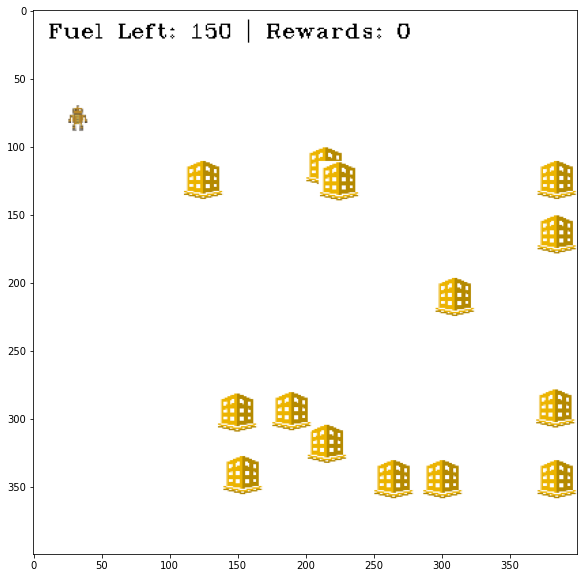

In [14]:
obstical_env = env.set_obsticals(full_obstacle_list)
plt.figure(figsize=(10, 10))
plt.imshow(obstical_env)

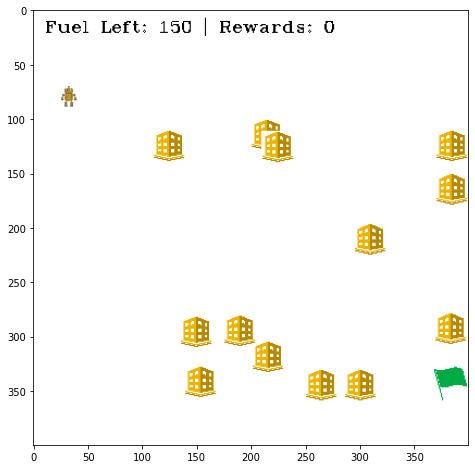

In [15]:
goal_pos = [[700,700]]
obstical_env = env.set_goal(goal_pos)
plt.figure(figsize=(8, 8))
plt.imshow(obstical_env)

In [16]:
from IPython import display

env = Robot_Env()
obs = env.reset()

goal_pos = [[380,380]]
full_obstacle_list = [ (200,100), (400,150),(400, 110), 
                 (430, 390), (201, 304), (135, 281), 
                 (286, 373), (175, 280), (250, 375), (139, 327), (369, 278), 
                 (295, 196), (210, 111),(110,110)]


env.set_obsticals(full_obstacle_list)
env.set_goal(goal_pos)


while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    
    # Render the game
    #env.render()
    
    if done == True:
        break

env.close()

In [17]:
def pre_process(image_frame):
    
   
    I = image_frame[20:] # Crop
    
    #print("Croped Image size : ",I.shape)
    I = cv2.resize(I,(128,128))
    return I.astype(np.float32)

In [18]:
"""
action = env.action_space.sample()
obs, reward, done, info = env.step(action)
print("Action : ",action)
print("Reward : ",reward)
print("is done : ",done)
print("info : ",info)
print("Image size : ",obs.shape)
plt.imshow(obs)
"""

'\naction = env.action_space.sample()\nobs, reward, done, info = env.step(action)\nprint("Action : ",action)\nprint("Reward : ",reward)\nprint("is done : ",done)\nprint("info : ",info)\nprint("Image size : ",obs.shape)\nplt.imshow(obs)\n'

Pre process image :  (128, 128, 3)


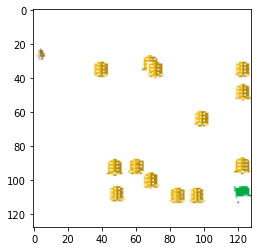

In [19]:
test_img = obs
pre_process_img = pre_process(test_img)
print("Pre process image : ",pre_process_img.shape)
plt.imshow(pre_process_img)

In [20]:
n_actions = 5
MAX_ITERS= 1000
learning_rate=1e-3
IMG_SIZE = 128

In [21]:
#!pip install tensorflow

In [22]:
import tensorflow as tf

C:\Users\tharh\anaconda3\envs\tharhtet\lib\site-packages\h5py\__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
C:\Users\tharh\anaconda3\envs\tharhtet\lib\site-packages\scipy\fft\__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
C:\Users\tharh\anaconda3\envs\tharhtet\lib\site-packages\scipy\sparse\sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
C:\Users\tharh\anaconda3\envs\tharhtet\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [23]:
def create_model():
    pre_train = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape= (IMG_SIZE, IMG_SIZE,3))
    x= pre_train.output
    x =  tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(1024, activation="relu",name='hidden_layer1')(x)
    x = tf.keras.layers.Dense(1024, activation="relu",name='hidden_layer2')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(512, activation="relu",name='hidden_layer3')(x)
    x = tf.keras.layers.Dense(512, activation="relu",name='hidden_layer4')(x)
    preds =tf.keras.layers.Dense(n_actions,activation='sigmoid', name='output')(x)
    model=tf.keras.Model(inputs=pre_train.input,outputs=preds)
    return model

In [24]:
model = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [25]:
def normalize(x):
    x = x - np.mean(x)
    x =  x / np.std(x)
    
    return x.astype(np.float32) 

In [26]:
def isNan(val):
     return val != val

In [27]:
def discount_rewards(rewards, gamma = 0.99):
    discounted_rewards = np.zeros_like(rewards)
    
    R =  0 
    for t in reversed(range (0,len(rewards))):
        
        if rewards[t] != 0 :
            R = 0
        R = R * gamma + rewards[t]
        
        
        discounted_rewards[t] = R
        
    return normalize(discounted_rewards)

In [28]:
class Memory:
    def __init__(self):
        self.clear()
        
    
    def clear(self):
        self.observations = []
        self.actions = []
        self.rewards = []
        
    def add_to_memory(self,new_observation,new_action,new_reward):
        self.observations.append(new_observation)
        
        self.actions.append(new_action)
        
        self.rewards.append(new_reward)

In [29]:
def choose_action(model,observation):
    
    observation = np.expand_dims(observation,axis = 0)
    
    logits = model.predict(observation)
    
    prob_weights = tf.nn.softmax(logits).numpy()
    
    isContainNan =  [ isNan(x) for x in prob_weights.flatten()]
    
    if True in   isContainNan:
        return np.random.choice(n_actions,size = 1)[0]
    
    action = np.random.choice(n_actions,size = 1, p = prob_weights.flatten())[0]
    
    return action

In [30]:
### Loss function ###
def compute_loss(logits,actions,rewards):
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = actions)

    loss = tf.reduce_mean(neg_logprob * rewards)

    return loss

### logging

In [31]:
import IPython
import time
from IPython import display as ipythondisplay

In [32]:
class LossHistory:
    def __init__(self, smoothing_factor=0.0):
        self.alpha = smoothing_factor
        self.loss = []
    def append(self, value):
        self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
    def get(self):
        return self.loss

In [33]:
class PeriodicPlotter:
    def __init__(self, sec, xlabel='', ylabel='', scale=None):

        self.xlabel = xlabel
        self.ylabel = ylabel
        self.sec = sec
        self.scale = scale

        self.tic = time.time()

    def plot(self, data):
        if time.time() - self.tic > self.sec:
            plt.cla()

            if self.scale is None:
                plt.plot(data)
            elif self.scale == 'semilogx':
                plt.semilogx(data)
            elif self.scale == 'semilogy':
                plt.semilogy(data)
            elif self.scale == 'loglog':
                plt.loglog(data)
            else:
                raise ValueError("unrecognized parameter scale {}".format(self.scale))

            plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
 
            self.tic = time.time()

In [34]:
# plotting
smoothed_reward = LossHistory(smoothing_factor=0.9)
plotter = PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')
memory = Memory()

In [35]:
### Training step (forward and backpropagation) ###
def train_step(model,optimizer,observations,actions,discounted_rewards):
    with tf.GradientTape() as tape:
        logits = model(observations)
        
        loss = compute_loss(logits,actions,discounted_rewards)
        #wandb.log({"loss": loss}) 
    grads = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

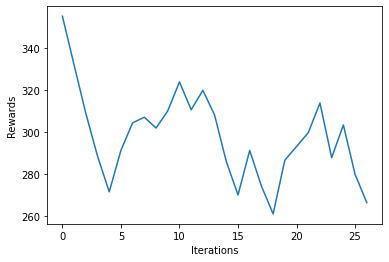

In [ ]:
for i_episode in range(MAX_ITERS):
    plotter.plot(smoothed_reward.get())
    
    # Restart the environment
    observation = env.reset()
    env.set_obsticals(full_obstacle_list)
    env.set_goal(goal_pos)

    previous_frame = pre_process(observation)
    
    while True :
        current_frame =  pre_process(observation)
        
        obs_change = current_frame # - previous_frame
        
        action = choose_action(model,obs_change)
        env.render()
        next_observation, reward, done, info = env.step(action)
        
        memory.add_to_memory(obs_change,action,reward)
        
        if done :
            
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)
            #wandb.log({"total_reward": total_reward})
            train_step(model,
                      optimizer,
                      observations = np.stack(memory.observations,0),
                      actions = np.array(memory.actions),
                      discounted_rewards = discount_rewards(memory.rewards))
            memory.clear()
            break
        
        observation = next_observation
        previous_frame = current_frame

In [ ]:
model.save("static2-9_5_2022.h5")

In [ ]:
print("hello")